# Calcolo del rendimento medio

autore: **Massimo Lauria**


Vediamo come calcolare i tassi di rendimento di alcuni titoli dalle loro quotazioni, per poi fare delle statistiche su di essi. I dati che useremo sono ottenuti dal sito https://it.investing.com/ e corrispondono ad un intervallo temporale di un anno, che va dal 2019/04/25 al 2020/4/24. 

Il valore di ognuno di questi titoli è contenuto in un file CSV (comma separated values) che non è altro che un file che contiene una tabella di valori. In particolare consideriamo il valore dei titoli

 - Banca intesa [ISP](ISP.IntesaSpa.csv)
 - UniCredit [CRDI](CRDI.Unicredit.csv)
 - Fiat Crysler [FCHA](FCHA.Fiat.csv)
 - Telecom Italia [TLIT](TLIT.Telecom.csv)

e ne valutiamo la prestazione in relazione al valore dell'indice di mercato [FTSEMIB](FTSEMIB.csv)

Per ogni titolo calcoliamo:
- tasso di rendimento giornaliero
- media, deviazione standard e varianza del tasso di ogni titolo
- indice $\beta$ o di [rischio sistematico](https://it.wikipedia.org/wiki/Beta_(finanza))

e ripeteremo questo calcolo per tre intervalli: una mese, sei mesi, un anno.


## Come leggere i dati da un file

Il sequente codice utilizza la libreria `pandas`, che permette di leggere un file CSV e ottenere una rappresentazione Python della tabella. Vediamo un esempio


In [1]:
import pandas

Tabella=pandas.read_csv(
             "ISP.IntesaSpa.csv",     # nome de file
            parse_dates=True,        # le date non sono semplice testo
            dayfirst=True,
            thousands=".",           
            decimal=",")

Tabella

,Data,Ultimo,Apertura,Massimo,Minimo,Vol.,Var. %
0,24042020,1.3438,1.3600,1.3858,1.3416,"118,16M","-2,93%"
1,23042020,1.3844,1.3520,1.4046,1.3400,"133,35M","3,45%"
2,22042020,1.3382,1.3378,1.3508,1.3244,"110,63M","1,38%"
3,21042020,1.3200,1.3590,1.3662,1.3172,"150,44M","-4,56%"
4,20042020,1.3830,1.3824,1.3884,1.3440,"110,03M","0,49%"
...,...,...,...,...,...,...,...
248,2052019,2.3270,2.3300,2.3580,2.3130,"107,18M","-0,43%"
249,30042019,2.3370,2.3260,2.3460,2.3180,"119,01M","0,21%"
250,29042019,2.3320,2.3050,2.3390,2.3000,"131,40M","2,06%"
251,26042019,2.2850,2.2720,2.2880,2.2620,"85,16M","0,35%"


È possibile anche estrarre una o più colonne, e/o un sottoinsieme di righe.

In [2]:
Tabella["Apertura"]

0      1.3600
1      1.3520
2      1.3378
3      1.3590
4      1.3824
        ...  
248    2.3300
249    2.3260
250    2.3050
251    2.2720
252    2.2770
Name: Apertura, Length: 253, dtype: float64

In [3]:
Tabella["Apertura"][10:30]

10    1.4420
11    1.5100
12    1.4100
13    1.4240
14    1.4330
15    1.4350
16    1.4946
17    1.5260
18    1.5912
19    1.5918
20    1.6278
21    1.5122
22    1.3954
23    1.4500
24    1.4626
25    1.3900
26    1.4442
27    1.4800
28    1.5702
29    1.6800
Name: Apertura, dtype: float64

## I parametri dell'analisi

È buona norma separare i dati dalle procedure, in modo tale che si possano facilmente replicare le analisi utilizzando dati diversi. Il codice che segue è più o meno indipendente da questi parametri, a parte per degli esempi esplicativi.

### Portafoglio dei titolo

La variabile `portafoglio` è un dizionario che associa ad ogni titolo il file contenente le sue quotazioni. Uno dei file in realtà non è realmente un titolo ma è l'indice di mercato. Mettiamo *forzatamente* anche questo nel dizionario `portafoglio` perché dovremo elaborarlo insieme agli altri.

In [4]:
portafoglio = {
    "ISP": "ISP.IntesaSpa.csv",
    "CRDI": "CRDI.Unicredit.csv",
    "FCHA": "FCHA.Fiat.csv",
    "TLIT": "TLIT.Telecom.csv",
    "FTSEMIB": "FTSEMIB.csv"
}

marketidx = "FTSEMIB"  # Indice di mercato

Di tutte le informazioni che sono contenute nei file a noi interessa semplicemente sapere la quotazione finale della giornata contenuta nella colonna **Ultimo**. La data di quella quotazione contenuta nel campo **Data**.

In [5]:
colonna_data = 'Data'
colonna_quoatazioni = 'Ultimo'

### Periodi temporali

Per ogni titolo calcoleremo delle statistiche su un mese, sei mesi, un anno.

In [6]:
periodi = [("un mese", '2020-03-25', '2020-04-24'),
           ("sei mesi", '2019-10-25', '2020-04-24'),
           ("un anno", '2019-04-25', '2020-04-24')]

## Lettura e pulizia dei dati

Per facilitarci la vita, mettiamo in una singola tabella `quotazioni` tutti i dati di cui avremo bisogno. Le righe della tabella vengono indicizzate dalla data delle quotazioni, e ogni riga contiene le quotazioni dei titoli che stiamo considerando. La variabile `intervallo` è un intervallo di date che costruiamo per utilizzarlo come indice delle tabelle che per ora sono ancora vuote.

In [7]:
data_minima = min(p[1] for p in periodi)    # data più piccola che compare
data_massima = max(p[2] for p in periodi)   # data più grande che compare

intervallo = pandas.date_range(start=data_minima, end=data_massima, freq='D')

# Tabelle senza colonne
quotazioni = pandas.DataFrame(index=intervallo)
rendimenti = pandas.DataFrame(index=intervallo)

In [8]:
quotazioni

""
2019-04-25
2019-04-26
2019-04-27
2019-04-28
2019-04-29
...
2020-04-20
2020-04-21
2020-04-22
2020-04-23


Da ogni file del nostro portafogli leggiamo i dati e copiamo la colonna **Ultimo** nella tabella `quotazioni`.

In [9]:
for t in portafoglio:     # t è la sigla del titolo

    temp = pandas.read_csv(
        portafoglio[t],         # nome de file corrispondente a t
        index_col=colonna_data, # usiamo le date come indice, non i valori 0,1,2,...
        parse_dates=True,       # l'indice è una data
        dayfirst=True,
        thousands=".",
        decimal=",")

    quotazioni[t] = temp['Ultimo'] 

In [10]:
quotazioni

,ISP,CRDI,FCHA,TLIT,FTSEMIB
2019-04-25,2.2770,12.056,13.732,0.4883,21719.88
2019-04-26,2.2850,12.072,13.858,0.4993,21737.97
2019-04-27,NaN,NaN,NaN,NaN,NaN
2019-04-28,NaN,NaN,NaN,NaN,NaN
2019-04-29,2.3320,12.362,13.824,0.5014,21788.54
...,...,...,...,...,...
2020-04-20,1.3830,6.897,7.430,0.3490,17064.14
2020-04-21,1.3200,6.590,7.098,0.3369,16450.85
2020-04-22,1.3382,6.718,7.250,0.3354,16765.28
2020-04-23,1.3844,6.900,7.505,0.3467,17011.11


### Ci sono dati mancanti

Per poter elaborare questi dati dobbiamo pulirli. I dati mancanti saranno interpolati da quelli presenti.

In [11]:
# Interpolo i valori dei giorni mancanti
quotazioni = quotazioni.interpolate(method='time', limit_direction='both')
quotazioni

,ISP,CRDI,FCHA,TLIT,FTSEMIB
2019-04-25,2.277000,12.056000,13.732000,0.4883,21719.880000
2019-04-26,2.285000,12.072000,13.858000,0.4993,21737.970000
2019-04-27,2.300667,12.168667,13.846667,0.5000,21754.826667
2019-04-28,2.316333,12.265333,13.835333,0.5007,21771.683333
2019-04-29,2.332000,12.362000,13.824000,0.5014,21788.540000
...,...,...,...,...,...
2020-04-20,1.383000,6.897000,7.430000,0.3490,17064.140000
2020-04-21,1.320000,6.590000,7.098000,0.3369,16450.850000
2020-04-22,1.338200,6.718000,7.250000,0.3354,16765.280000
2020-04-23,1.384400,6.900000,7.505000,0.3467,17011.110000


## Calcolo del tasso di rendimento giornalierio

Se la quotazione di un titolo è rappresentato dalla sequenza 
$$
v_1, v_2, v_3, \ldots
$$
allora il rendimento del titolo al tempo $t$ è dato dal valore di
$$
\log\frac{v_i}{v_{i-1}}
$$
che può essera calcolato facilmente utilizzando il metodo `shift` e la funzione *vettorizzata* `log` della libreria `numpy`.


In [12]:
# Calcolo i rendimenti
import numpy

for t in portafoglio:
    rendimenti[t] = numpy.log(quotazioni[t] / quotazioni[t].shift(1))
    
rendimenti

,ISP,CRDI,FCHA,TLIT,FTSEMIB
2019-04-25,NaN,NaN,NaN,NaN,NaN
2019-04-26,0.003507,0.001326,0.009134,0.022277,0.000833
2019-04-27,0.006833,0.007976,-0.000818,0.001401,0.000775
2019-04-28,0.006787,0.007913,-0.000819,0.001399,0.000775
2019-04-29,0.006741,0.007850,-0.000819,0.001397,0.000774
...,...,...,...,...,...
2020-04-20,0.001640,0.001645,0.004857,0.003828,0.000169
2020-04-21,-0.046623,-0.045533,-0.045713,-0.035286,-0.036602
2020-04-22,0.013694,0.019237,0.021188,-0.004462,0.018933
2020-04-23,0.033941,0.026731,0.034568,0.033136,0.014557


### Riduzione della finestra temporale (esempio)

Abbiamo detto che vogliamo fare statistica sui rendimenti appena calcolati, ma su diverse finestre temporali. Vediamo un esempio di come farlo su una finestra temporale di una settimana. Il calcolo effettivo verrà invece ripetuto per i periodi indicati della variabile `periodi`. 

*Osservazione*: se vengono cambiati i dati nella sezione "I parametri dell'analisi", il codice di queste analisi dovrebbe continuare a funzionare sui nuovi dati. L'esempio che segue però ha scopo illustrativo e per ragioni didattiche non è ben parametrizzato.

In [13]:
finestra = pandas.date_range(start="2019-07-21", end="2019-07-27", freq='D')
rendimentiStat = pandas.DataFrame(index=finestra)
rendimentiStat

""
2019-07-21
2019-07-22
2019-07-23
2019-07-24
2019-07-25
2019-07-26
2019-07-27


In [14]:
# Proietto sulla finesta temporale
rendimentiStat["ISP"] = rendimenti["ISP"]
rendimentiStat["FTSEMIB"] = rendimenti["FTSEMIB"]
rendimentiStat

,ISP,FTSEMIB
2019-07-21,0.000581,0.001448
2019-07-22,0.000580,0.001446
2019-07-23,0.011615,0.010023
2019-07-24,0.000000,0.005707
2019-07-25,-0.007398,-0.008050
2019-07-26,-0.004963,-0.002997
2019-07-27,-0.003123,-0.001962


Per calcolare le quatto statistiche si può usare il metodo `aggregate` che calcola una o più funzioni statistiche su ogni colonna della tabella. Per le funzioni standard come *media*, *varianza*, *deviazionbe standard* è sufficiente specificare il nome della funzione da applicare.

In [15]:
rendimentiStat.aggregate(['mean', 'std', 'var'])

,ISP,FTSEMIB
mean,-0.000387,0.000802
std,0.006105,0.005921
var,0.000037,0.000035


La funzione che calcola $\beta$ deve essere realizzata esplicitamente. Matematicamente, il $\beta$ di un titolo, ad esempio **ISP**, è la covarianza tra i rendimenti di **ISP** e i rendimenti dell'indice di mercato (in questo caso **FTSEMIB**), diviso dalla varianza dell'indice di mercato stesso.


In [16]:
import numpy

varmarket = numpy.var(rendimentiStat["FTSEMIB"])  # var dell'indice di mercato\

# La funzione che calcola beta
def beta(quotazioni):
    return quotazioni.cov(rendimentiStat["FTSEMIB"]) / varmarket

rendimentiStat.aggregate(['mean', 'std', 'var',beta])

,ISP,FTSEMIB
mean,-0.000387,0.000802
std,0.006105,0.005921
var,0.000037,0.000035
beta,1.113828,1.166667


### Statistiche sulle tre finestre temporali

Ripetiamo il calcolo visto su tutti i titoli del portafoglio per le finestre temporali indicate. Il calcolo è esattamente lo stesso. Manterremo i dati in due dizionari che associano ad ogni intervallo temporare i relativi tassi giornalieri e le statistiche calcolate.

In [17]:
# Dati delle finestre temporali
rendimentiF = {}
statisticheF = {}

In [18]:
for p in periodi:

    nome = p[0]
    inizio = p[1]
    fine = p[2]

    # Finestra temporale
    finestra = pandas.date_range(start=inizio, end=fine, freq='D')
    rendimentiF[nome] = pandas.DataFrame(index=finestra)

    # Proietto sulla finesta temporale
    for t in portafoglio:
        rendimentiF[nome][t] = rendimenti[t]

    # Statistiche dei rendimenti
    varmarket = numpy.var(
        rendimentiF[nome][marketidx])  # var dell'indice di mercato

    def beta(quotazioni):
        return quotazioni.cov(rendimentiF[nome][marketidx]) / varmarket

    statisticheF[nome] = rendimentiF[nome].aggregate(
        ['mean', 'std', 'var', beta])

In [19]:
rendimentiF['sei mesi']

,ISP,CRDI,FCHA,TLIT,FTSEMIB
2019-10-25,0.000660,-0.006223,-0.000844,0.001878,0.003614
2019-10-26,0.000880,0.001386,0.001743,0.000000,0.001277
2019-10-27,0.000879,0.001384,0.001740,0.000000,0.001275
2019-10-28,0.000878,0.001382,0.001737,0.000000,0.001273
2019-10-29,-0.002857,0.010478,-0.013525,-0.003759,-0.000657
...,...,...,...,...,...
2020-04-20,0.001640,0.001645,0.004857,0.003828,0.000169
2020-04-21,-0.046623,-0.045533,-0.045713,-0.035286,-0.036602
2020-04-22,0.013694,0.019237,0.021188,-0.004462,0.018933
2020-04-23,0.033941,0.026731,0.034568,0.033136,0.014557


In [20]:
statisticheF['sei mesi']

,ISP,CRDI,FCHA,TLIT,FTSEMIB
mean,-0.002867,-0.003012,-0.002614,-0.002490,-0.001584
std,0.023436,0.026984,0.028430,0.025858,0.020208
var,0.000549,0.000728,0.000808,0.000669,0.000408
beta,1.087278,1.164749,1.109053,0.950751,1.005495


In [21]:
rendimentiF['un anno']

,ISP,CRDI,FCHA,TLIT,FTSEMIB
2019-04-25,NaN,NaN,NaN,NaN,NaN
2019-04-26,0.003507,0.001326,0.009134,0.022277,0.000833
2019-04-27,0.006833,0.007976,-0.000818,0.001401,0.000775
2019-04-28,0.006787,0.007913,-0.000819,0.001399,0.000775
2019-04-29,0.006741,0.007850,-0.000819,0.001397,0.000774
...,...,...,...,...,...
2020-04-20,0.001640,0.001645,0.004857,0.003828,0.000169
2020-04-21,-0.046623,-0.045533,-0.045713,-0.035286,-0.036602
2020-04-22,0.013694,0.019237,0.021188,-0.004462,0.018933
2020-04-23,0.033941,0.026731,0.034568,0.033136,0.014557


In [22]:
statisticheF['un anno']

,ISP,CRDI,FCHA,TLIT,FTSEMIB
mean,-0.001445,-0.001614,-0.001712,-0.001014,-0.000694
std,0.018498,0.022329,0.023025,0.020584,0.015452
var,0.000342,0.000499,0.000530,0.000424,0.000239
beta,1.095495,1.209802,1.120032,0.977395,1.002747


## Plot dei dati

Il tasso di rendimento giornaliero di un titolo pare essere distribuito tendenzialmente come una Gaussiana con la stessa media e scarto quadratico dei dati stessi. Vediamo cosa succede se mettiamo a confronto i dati con le Gaussiane corrispondenti. Il plot sarà organizzato in righe e colonne. Su tre colonne i dati delle tre finestre temporali, con un titolo per ogni riga.

In [23]:
INTERVALLI = [p[0] for p in periodi]
TITOLI   = list(portafoglio.keys())
TITOLI.remove(marketidx)

INTERVALLI, TITOLI

(['un mese', 'sei mesi', 'un anno'], ['ISP', 'CRDI', 'FCHA', 'TLIT'])

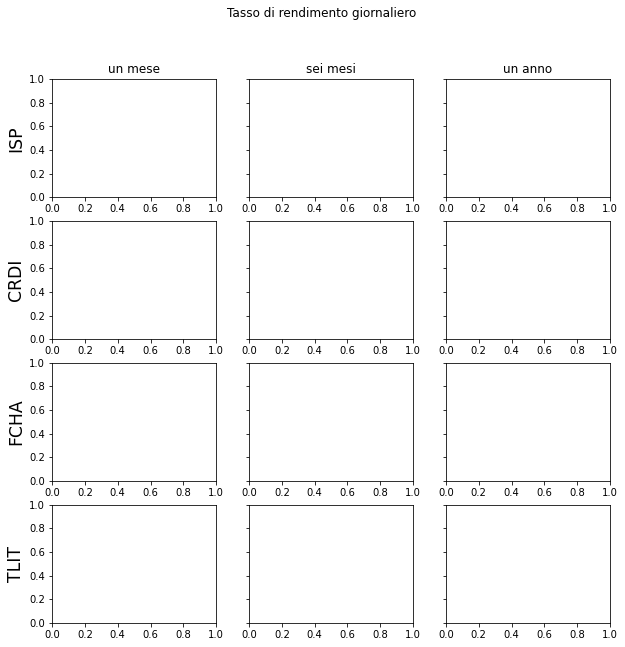

In [24]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(len(TITOLI), len(INTERVALLI), sharey='row')
fig.suptitle("Tasso di rendimento giornaliero")
fig.set_facecolor('white')
fig.set_figwidth(10) 
fig.set_figheight(10) 

for ax, col in zip(axs[0], INTERVALLI):
    ax.set_title(col)

for ax, row in zip(axs[:, 0], TITOLI):
    ax.set_ylabel(row, size='xx-large')
    

Abbiamo lo schema del plot, e adesso per ogni cella vediamo l'istogramma dei tassi di rendimenti giornalieri per il dato titolo e il dato intervallo temporale, messo a confronto con la Gaussiana corrispondete. 

La funzione che calcola la densità di probabilità della distribuzione normale è nella funzione `norm` della libreria `scipy.stats`.



In [25]:
from scipy.stats import norm

for j, f in enumerate(INTERVALLI):
    for i, t in enumerate(TITOLI):

        mu = statisticheF[f][t]['mean']
        si = statisticheF[f][t]['std']
        x = numpy.arange(mu - 3 * si, mu + 3 * si, 0.01)
        y = norm.pdf(x, loc=mu, scale=si)
        axs[i][j].hist(rendimenti[t],
                       bins=15,
                       density=True,
                       rwidth=0.9,
                       color='#86bf91')

        axs[i][j].plot(x, y)
        axs[i][j].fill_between(x, y, 0, alpha=0.1, color='b')
        axs[i][j].grid(False)

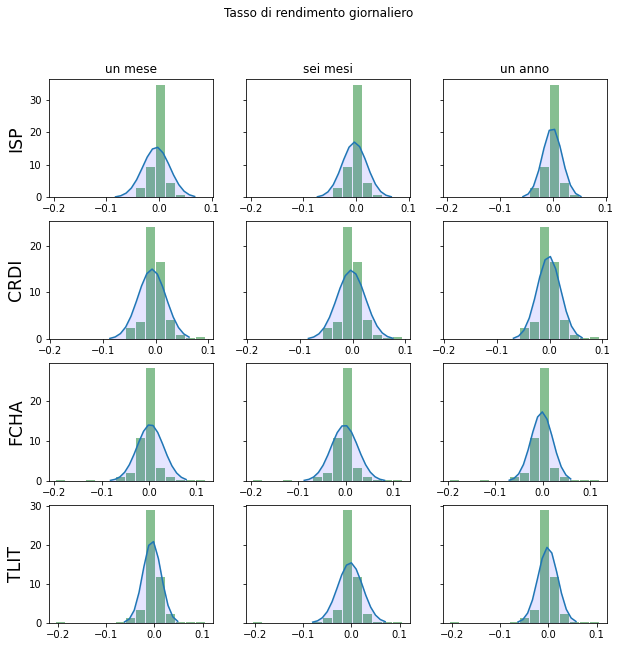

In [26]:
fig

In [27]:
fig.savefig("rendimentomedio.png")